In [10]:
import h3ppy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy.io as sio
import os
from pathlib import Path
from matplotlib.colors import LogNorm as lognorm
plt.rcParams.update({'font.size': 16})

In [2]:
path = "Y:/obs_23/Keck_29Dec"


#open up a few files to check the wavecal and confirm the lines being used
jup1_data = np.load(path + r"/spec/e1o1/Kate's Files/fcal data/interp/nspec231230_0035_JupN_e1o1_final_interp.npy")
jup4_data = np.load(path + r"/spec/e1o4/Kate's Files/fcal data/interp/nspec231230_0035_JupN_e1o4_final_interp.npy")


#wavelength calibration files
wave_e1o1_list = sio.readsav(path + r"\spec\e1o1\wavelength.sav", verbose=False, python_dict = True)
wave_micron1st = wave_e1o1_list['wavelength']

wave_e1o4_list = sio.readsav(path + r"\spec\e1o4\wavelength.sav", verbose=False, python_dict = True)
wave_micron4th = wave_e1o4_list['wavelength']



#_________________________________________________#

#choose an index to start testing with - this is just a position along the slit (in the spatial dimension)
num = 172 #can be an number from 0 to 185 generally with current setup - max is length of data in spatial dimension


#width of slice to take for each emission line, in # of data points from center of the line (treat as a radius, not a diameter)
widthpeaklist = [7, 15, 15, 15]



#emission lines to use for fitting - the length of these must be the same (since they correspond to each other)
centers_multi = [3.41488, 3.42071, 3.45475, 3.95299] #center of line peak in data
truecenters_multi = [3.41488, 3.42071, 3.45475, 3.95299] #actual wavelength of emission via h3ppy
#full list: 3.41277, 3.41488, 3.42071, 3.42697, 3.45475, 3.62046, 3.95299 #Possible emission lines in our data to check for fitting

#array of "seed" temperatures to input into h3ppy - these are in the realm of expected values
temps = [900, 1200, 1100, 1000, 800, 700, 1300, 1800, 600]


#input values for h3ppy - correspond to polynomials used to account for background, wavelength offsets between the lines, and line width
nbg = 0
noff = 3
nsig = 1

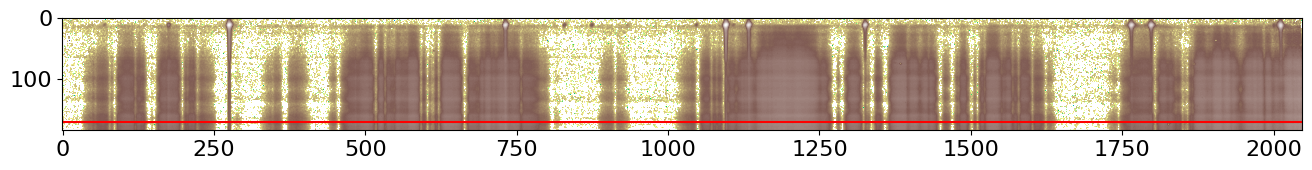

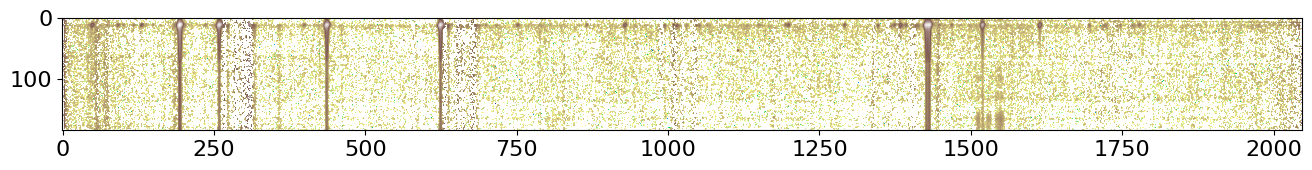

In [11]:
plt.subplots(figsize=[16, 8])
plt.imshow(jup1_data,norm = lognorm(), cmap = "terrain")
plt.axhline(y = num, c = "r", label = "Index: " + str(num))
#plt.legend()
plt.show()

plt.subplots(figsize=[16, 8])
plt.imshow(jup4_data,norm = lognorm(), cmap = "terrain")
#plt.axhline(y = num)
plt.show()

C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


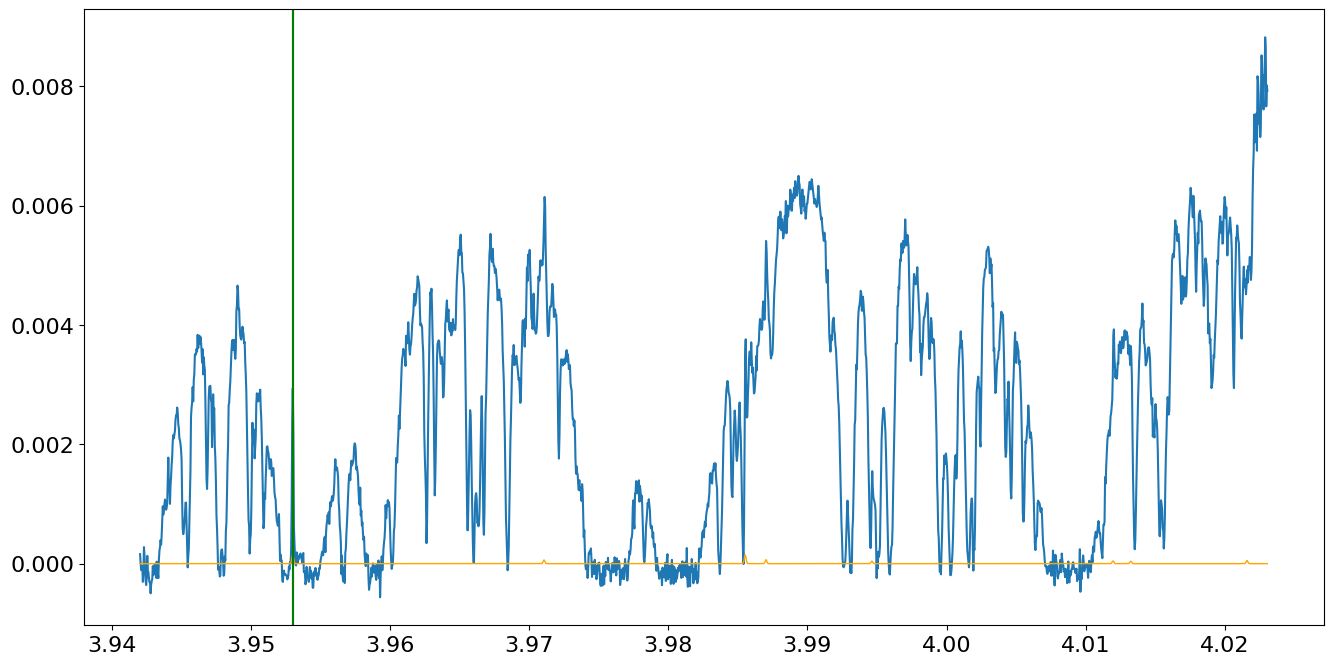

In [12]:
h3p = h3ppy.h3p()
wave = h3p.wavegen(wave_micron1st[0], wave_micron1st[2047], 10000)
model = h3p.model(density = 1e+14, temperature = 700, R = 25000, wavelength = wave)


plt.subplots(figsize=[16, 8])
plt.plot(wave_micron1st,jup1_data[num])
plt.plot(wave, model, color = "orange", linewidth=1, label='Model')


#plt.xlim(3.95, 3.96) #uncomment to get a better view of this emission line
plt.axvline(x = 3.95299, color = 'maroon', label = "H3ppy") #Q(1,0)
plt.axvline(x = 3.95299, color = 'green', label = "data") #change position to match with center of h3+ emission - sometimes wavecals aren't perfect

#you'll need to use the corrected emission line wavelength in the fitting process
#line list: 3.95299

C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


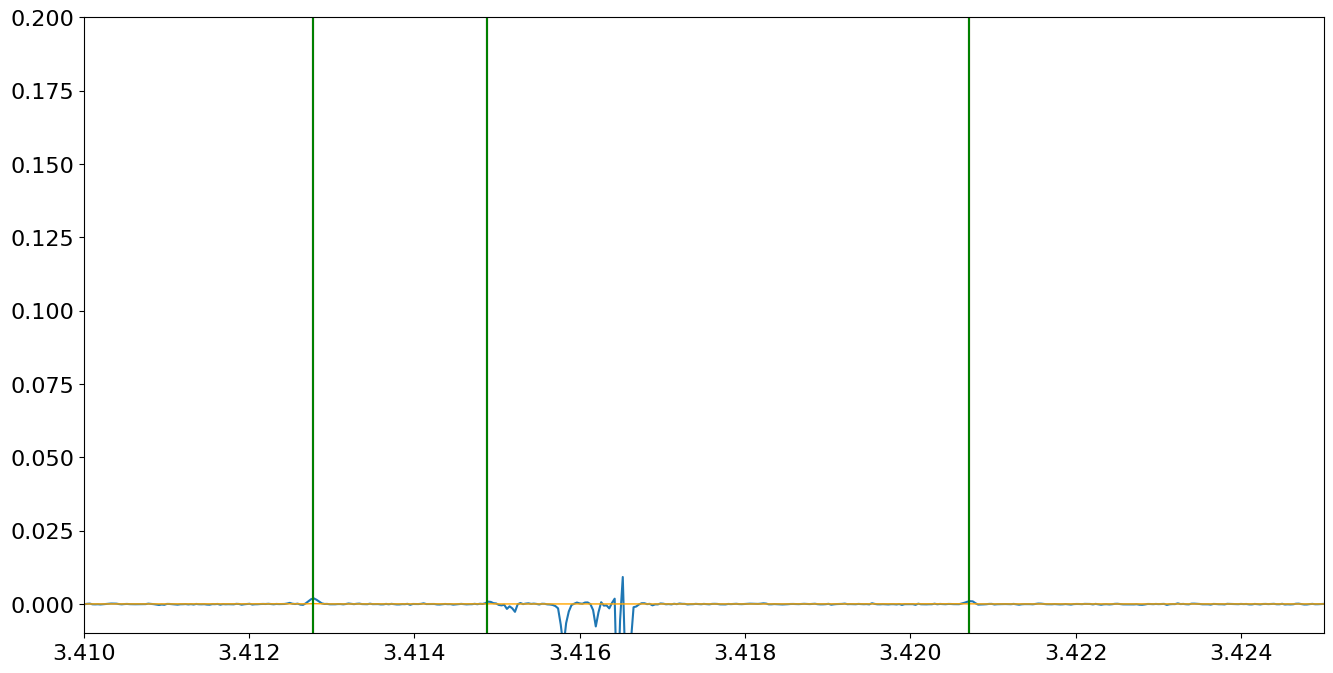

In [13]:
h3p = h3ppy.h3p()
wave = h3p.wavegen(wave_micron4th[0], wave_micron4th[2047], 10000)
model = h3p.model(density = 1e+14, temperature = 700, R = 25000, wavelength = wave)

plt.subplots(figsize=[16, 8])
plt.plot(wave_micron4th,jup4_data[num])
plt.plot(wave, model, color = "orange", linewidth=1, label='Model')

plt.ylim(-1e-2,2e-1)

plt.xlim(3.41, 3.425) #uncomment to get a better view of these emission lines
plt.axvline(x = 3.41277, color = 'maroon', label = "H3ppy")
plt.axvline(x = 3.41277, color = 'green', label = "data") #change position to match with center of h3+ emission

plt.axvline(x = 3.41488, color = 'maroon', label = "H3ppy")
plt.axvline(x = 3.41488, color = 'green', label = "data") #change position to match with center of h3+ emission

plt.axvline(x = 3.42071, color = 'maroon', label = "H3ppy")
plt.axvline(x = 3.42071, color = 'green', label = "data") #change position to match with center of h3+ emission

#plt.xlim(3.425, 3.43) #uncomment to get a better view of this emission line
plt.axvline(x = 3.42697, color = 'maroon', label = "H3ppy")
plt.axvline(x = 3.42697, color = 'green', label = "data") #change position to match with center of h3+ emission

#plt.xlim(3.45, 3.46) #uncomment to get a better view of this emission line
plt.axvline(x = 3.45475, color = "maroon", label = "H3ppy") #doublet
plt.axvline(x = 3.45475, color = "green", label = "data") #change position to match with center of h3+ emission


#line list: 3.41277, 3.41488, 3.42071, 3.42697, 3.45475

In [14]:
#my variation of subdivide (from h3ppy github) to include emission lines from two orders/arrays of data with varying widths for emission line slices

#wave1: wavelength values for first spectrum (1st order, microns)
#wave4: wavelength values for second spectrum (4th order, microns)
#spec1: first spectrum to be fit by h3ppy (1st order, W/m^2/micron/str)
#spec4: second spectrum to be fit by h3ppy (4th order, W/m^2/micron/str)
#middles: list of emission lines to be extracted (ACCORDING TO DATA) (microns)
#width: # of data points to be pulled from spectrum on either side of the middle of an emission line, a list of same size as middles

def subdivide_doubleorder_multiwidth(wave1, wave2, spec1, spec2, middles, width = widthpeaklist): 
    
    #make sure lists of emission lines and their cut widths are same size
    if len(middles) != len(width):
        print("Number of emission lines does not equal size of widths to slice")
    
    else:
        spec = []
        wave = []
        for i in range(len(spec1)):#...i don't know the right way to put the arrays together
            spec.append(spec1[i])       #this works I guess, but it looks ugly
        for i in range(len(spec2)):
            spec.append(spec2[i])
        for i in range(len(wave1)):
            wave.append(wave1[i])
        for i in range(len(wave2)):
            wave.append(wave2[i])

        spec = np.array(spec)
        wave = np.array(wave)

        ret = []
        for x in range(len(middles)): #loop through for each emission line entered
            centre = np.abs(wave - middles[x]).argmin() #subtracts value of middle from all data points;
                                               #absolute value -> closest to 0 is the index of the peak
            for i in range(centre - width[x], centre + width[x]) : #finds boundaries for region you want to "cut out"
                ret.append(spec[i]) #append "cut out" piece of wavelength values to final array
        return np.array(ret)

In [15]:
#function to find median value of data from +/- "width" of slit positions to essentially smooth across slit positions
widthdy = 3

def dy_median(data,width = widthdy):
    
    arr = []
    
    for i in range(len(data[:,1])):

        #everything within inner boundaries
        if i >= width and i < (len(data[:,1])-width):
            med = np.median(data[i-width:i+width,:], axis=0)
            arr.append(med)
        #getting all of the left edge stuff
        elif i<width:
            med = np.median(data[0:i+width,:], axis=0)
            arr.append(med)

        #getting all of the right edge stuff
        elif i>=(len(data[:,1])-width):
            med = np.median(data[i-width:len(data[:,1]), :], axis=0)
            arr.append(med)


        else:
            print("Unable to determine order: " + str(i))
            
    return arr

In [16]:
def line(x,m,b):
   return m * x + b

#only to be used on order 1!
def dy_wo_aurora1(data):
    
    dy = np.zeros([len(data), len(data[0])])
    summed = np.sum(data, axis = 1) #sum in wavelength direction to later find auroral peak
    
    x_values = np.linspace(0,len(summed),len(summed)) #array of values for "x-axis"
    popt, pcov = curve_fit(line,x_values,summed) #fit line to summed array - tends to have an anti-auroral positive slope
    flattened = np.sum(data, axis = 1)/ line(x_values, *popt) #eliminating slope of emission across slit
    
    #first looking for whether the max of the first auroral section is smaller than the max of the second 
    #if yes, aurora is on "right" side (from this perspective)
    if np.max(flattened[0:int(0.3*len(summed))]) < np.max(flattened[len(summed) - int(0.3*len(summed)):len(summed)]):
        #find index of auroral emission peak
        maxauroraindex = flattened[len(summed) - int(0.3*len(summed)):len(summed)].argmax() + len(summed) - int(0.3*len(summed))
        #find value of region between auroral index peak & midpoint of slit which is closest to 10% of the peak
        dropindex = maxauroraindex - int(0.30*len(summed))
        #print(dropindex)
        #apply dy to non-auroral region
        dy[:dropindex] = dy_median(data[:dropindex])
        
        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[dropindex:])):
            dy[dropindex + i] = data[dropindex + i]


    #first looking for whether the max of the first auroral section is larger than the max of the second 
    #if yes, aurora is on "left" side (from this perspective)
    elif np.max(flattened[0:int(0.3*len(summed))]) > np.max(flattened[len(summed) - int(0.3*len(summed)):len(summed)]):
        #find index of auroral emission peak
        maxauroraindex = flattened[0:int(0.3*len(summed))].argmax()
        #find value of region between auroral index peak & midpoint of slit which is closest to 10% of the peak
        dropindex = maxauroraindex + int(0.30*len(summed))


        
        #apply dy to non-auroral region
        dy[dropindex:] = dy_median(data[dropindex:])

        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[:dropindex])):
            dy[i] = data[i]

    else:
        print("Unable to determine aurora location")
            
    #plt.axvline(x = dropindex, color = "red")        

    return np.asarray(dy), dropindex


#only to be used on order 3 or 4!
def dy_wo_aurora34(data, index):
    
    dy = np.zeros([len(data), len(data[0])])
    summed = np.sum(data, axis = 1) #sum in wavelength direction to later find auroral peak

    
    if index >= len(summed)*0.5:
        #print("Aurora on Right")
        #use index found in pt 1
        dropindex = index
        #print(dropindex)
        #apply dy to non-auroral region
        dy[:dropindex] = dy_median(data[:dropindex])
        
        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[dropindex:])):
            #print(i)
            dy[dropindex + i] = data[dropindex + i]


    #if yes, aurora is on "left" side (from this perspective)
    elif index < len(summed)*0.5:
        #print("Aurora on Left")
        #use index found in pt 1
        dropindex = index
        #print(dropindex)
        #apply dy to non-auroral region
        dy[dropindex:] = dy_median(data[dropindex:])

        #append in rest of data, resulting in smoothed equatorial region & unsmoothed auroral
        for i in range(len(data[:dropindex])):
            #print(i)
            dy[i] = data[i]

    else:
        print("Unable to determine drop index location")

    return np.asarray(dy) #, np.abs(dropindex)

In [17]:
#function to loop through all spectra in array to fit with h3ppy and return temp, density, and errors
            #this version specific to using lines from 2 orders
#wavelength1: the array of wavelength values which correspond to the data being fed in from order 1 (microns)
#wavelength4: the array of wavelength values which correspond to the data being fed in from order 4 (microns)
#data1x: the spectrum which is attempting to be fit by h3ppy from order 1 (W/m^2/micron/str)
#data4x: the spectrum which is attempting to be fit by h3ppy from order 4 (W/m^2/micron/str)
#middles: the values of the centers of the emission lines in the *data* (microns)
#truemiddles: the values of the centers of the corresponding emission lines in h3ppy (microns)
#temperatures: an array of temperature values for h3ppy to loop through (Kelvin)
#nbg: integer-value of nth order polynomial used for fitting the background in h3ppy
#noff: integer-value of nth order polynomial used for fitting the wavelength offsets (wavecal correction) in h3ppy
#nsig: integer-value of nth order polynomial used for fitting line widths in h3ppy

def h3ppyfit_doubleorder_loop_multiwidth(wavelength1, wavelength4, data1x, data4x, middles, truemiddles, temperatures, nbg, noff, nsig):
       
        
    temp = []
    density = []
    temperror = []
    densityerror = []
    
    fitlist = []
    datalist = []
    wavelengthlist = []
    
    count = 0
    tempcount = 0
    fail = 0
    
    data1, aurora_index = dy_wo_aurora1(data1x)
    data4 = dy_wo_aurora34(data4x, aurora_index)

    
    for i in range(len(data1)):  
        
        subspec = subdivide_doubleorder_multiwidth(wavelength1, wavelength4, data1[i], data4[i], middles)
        subwave = subdivide_doubleorder_multiwidth(wavelength1, wavelength4, wavelength1, wavelength4, truemiddles)
        
        datalist.append(subspec)
        wavelengthlist.append(subwave)
        
        h3p = h3ppy.h3p()
        # Set the wavelength and the data
        h3p.set(wavelength = subwave, data = subspec, R = 30000, nbackground = nbg, noffset = noff, nsigma = nsig)
        
        # We need to guess a temperature
        h3p.set(temperature = temperatures[0])

        # Let h3ppy try and guess a wavelength offset
        guess = h3p.guess_offset( verbose = False)
        # Guess the density and proceed with a multi-parameter fit
        h3p.guess_density(verbose = False)
        # Let h3ppy do the fitting - this will do a multi-parameter fit
        fit = h3p.fit(verbose = False)
        
        
        vars, errs = h3p.get_results(verbose = False)
        
        #if the initial temperature attempt fails, it goes into this loop
        if vars == False:
            
            
            
            while tempcount < len(temperatures) and vars == False:
                    
                h3p = h3ppy.h3p()
                # Set the wavelength and the data
                h3p.set(wavelength = subwave, data = subspec, R = 30000, nbackground = nbg, noffset = noff, nsigma = nsig)

                # We need to guess a temperature
                h3p.set(temperature = temperatures[tempcount])

                # Let h3ppy try and guess a wavelength offset
                guess = h3p.guess_offset( verbose = False)
                # Guess the density and proceed with a multi-parameter fit
                h3p.guess_density(verbose = False)
                # Let h3ppy do the fitting - this will do a multi-parameter fit
                fit = h3p.fit(verbose = False)
                
                vars, errs = h3p.get_results(verbose = False)
                
                tempcount = tempcount + 1
                            
                    
            if tempcount >= len(temperatures) and vars == False:
                #if all attmepts to fit the data fail (all seed temperatures are attempted), placeholders are input to move onto the next set of lines
                    temp.append(-666)
                    temperror.append(666)
                    density.append(-666)
                    densityerror.append(666)

                    fitlist.append(np.zeros(len(subwave)))

                    print("Unable to fit index " + str(count))

                    count = count + 1
                    tempcount = 0
                    fail = fail + 1
                
                
            
            #else:
            elif vars != False:
                temp.append(vars['temperature'])
                temperror.append(errs['temperature'])
                density.append(vars['density'])
                densityerror.append(errs['temperature'])
                
                fitlist.append(fit)
                
                count = count + 1
                tempcount = 0
            
            
            else:
                print("Something unexpected has happened at index: " + str(count))
            
            
        #this is for saving the results of a first-attmept success!
        else:
            temp.append(vars['temperature'])
            temperror.append(errs['temperature'])
            density.append(vars['density'])
            densityerror.append(errs['density'])
            
            fitlist.append(fit)
            
            count = count + 1
            tempcount = 0
            
            
    
    return temp,temperror,density,densityerror,datalist,fitlist,fail

In [18]:
#here's the testing zone:

#all this first section is for testing things initially 
#only for one temperature/density along the slit, really just to make sure your combo of emission lines, their widths, and h3ppy settings are working

In [19]:
#applying spatial smoothing factor to everywhere but the aurora
jup1_dy, aurora_index = dy_wo_aurora1(jup1_data)
jup4_dy = dy_wo_aurora34(jup4_data, aurora_index)

subspec = subdivide_doubleorder_multiwidth(wave_micron1st, wave_micron4th, jup1_dy[num], jup4_dy[num], truecenters_multi)
subwave = subdivide_doubleorder_multiwidth(wave_micron1st, wave_micron4th, wave_micron1st, wave_micron4th, truecenters_multi)
print("Len of subspec: " + str(len(subspec)))
print("Len of subwave: " + str(len(subwave)))

Len of subspec: 104
Len of subwave: 104


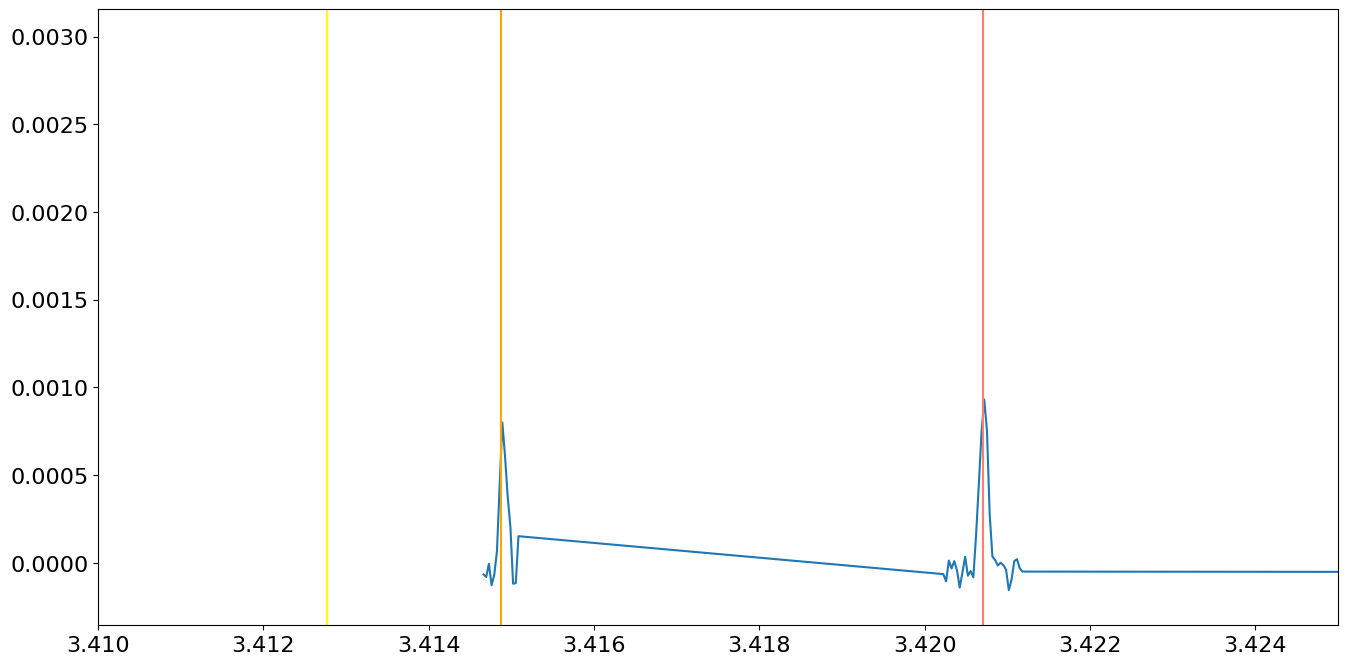

In [20]:
#check to make sure the peaks are at the "real" wavelength, rather than the bad wavecal wavelength (just that the peak center lines up with line)
#also a good place to check on whether the widths chosen were good for your emission lines
    #I'd reccomend 15 as a maximum (you just don't need more than 15), but you want to make sure there aren't any big contaminants

plt.subplots(figsize=[16, 8])
plt.plot(subwave, subspec)

plt.xlim(3.41, 3.425)
plt.axvline(x = 3.41277, color = "yellow")
plt.axvline(x = 3.41488, color = 'orange')
plt.axvline(x = 3.42071, color = 'salmon')


#plt.xlim(3.45, 3.46)
plt.axvline(x = 3.45475, color = "red")


#plt.xlim(3.95, 3.955)
plt.axvline(x = 3.95299, color = 'maroon')

#plt.legend()
plt.show()

In [21]:
h3p = h3ppy.h3p()

# Set the wavelength and the data
h3p.set(wavelength = subwave, data = subspec, R = 30000, nbackground = nbg, noffset = noff, nsigma = nsig)

# We need to guess a temperature
h3p.set(temperature = 900) #here you can change the starting seed temperature if the fit fails

# We need to guess a density?
#h3p.set(density = 4.0E14)

# Let h3ppy try and guess a wavelength offset
guess = h3p.guess_offset()
# Guess the density and proceed with a five parameter fit
h3p.guess_density()
# Let h3ppy do the fitting - this will do a full five parameter fit
fit = h3p.fit(verbose = True)

[h3ppy] Estimated offset =  0.00E+00 microns
[h3ppy] Estimated density = 7.50E+14 m-2
[h3ppy] Number of fitting iterations is set to 14


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Current paramter set:
        Temperature = 648.6
        Density     = 1.30E+15
        background_0 = -3.47E-05
        offset_0 = 2.42E-02
        offset_1 = -1.32E-02
        offset_2 = 1.79E-03
        sigma_0 = 5.29E-05

[h3ppy] The converger is 7.01E-01 after -1 iterations
[h3ppy] Current paramter set:
        Temperature = 731.1
        Density     = 1.58E+15
        background_0 = -7.03E-05
        offset_0 = 5.51E-02
        offset_1 = -3.00E-02
        offset_2 = 4.06E-03
        sigma_0 = 4.92E-05

[h3ppy] The converger is 3.64E-01 after 0 iterations
[h3ppy] Current paramter set:
        Temperature = 698.1
        Density     = 1.68E+15
        background_0 = -1.05E-04
        offset_0 = 3.84E-02
        offset_1 = -2.09E-02
        offset_2 = 2.84E-03
        sigma_0 = 5.06E-05

[h3ppy] The converger is 2.52E-01 after 1 iterations
[h3ppy] Current paramter set:
        Temperature = 701.3
        Density     = 1.66E+15
        background_0 = -1.40E-04
        offse

In [22]:
vars, errs = h3p.get_results()

[h3ppy]  Spectrum parameters:
         Temperature    = 701.6 +/- 16.4 [K]
         Column density = 1.66E+15 +/-  1.65E+14 [m-2]
         ------------------------------
         background_0 = -4.97E-04 +/- 1.21E-05
         offset_0 = 3.70E-02 +/- 3.67E-03
         offset_1 = -2.02E-02 +/- 2.00E-03
         offset_2 = 2.73E-03 +/- 2.70E-04
         sigma_0 = 5.02E-05 +/- 1.33E-06



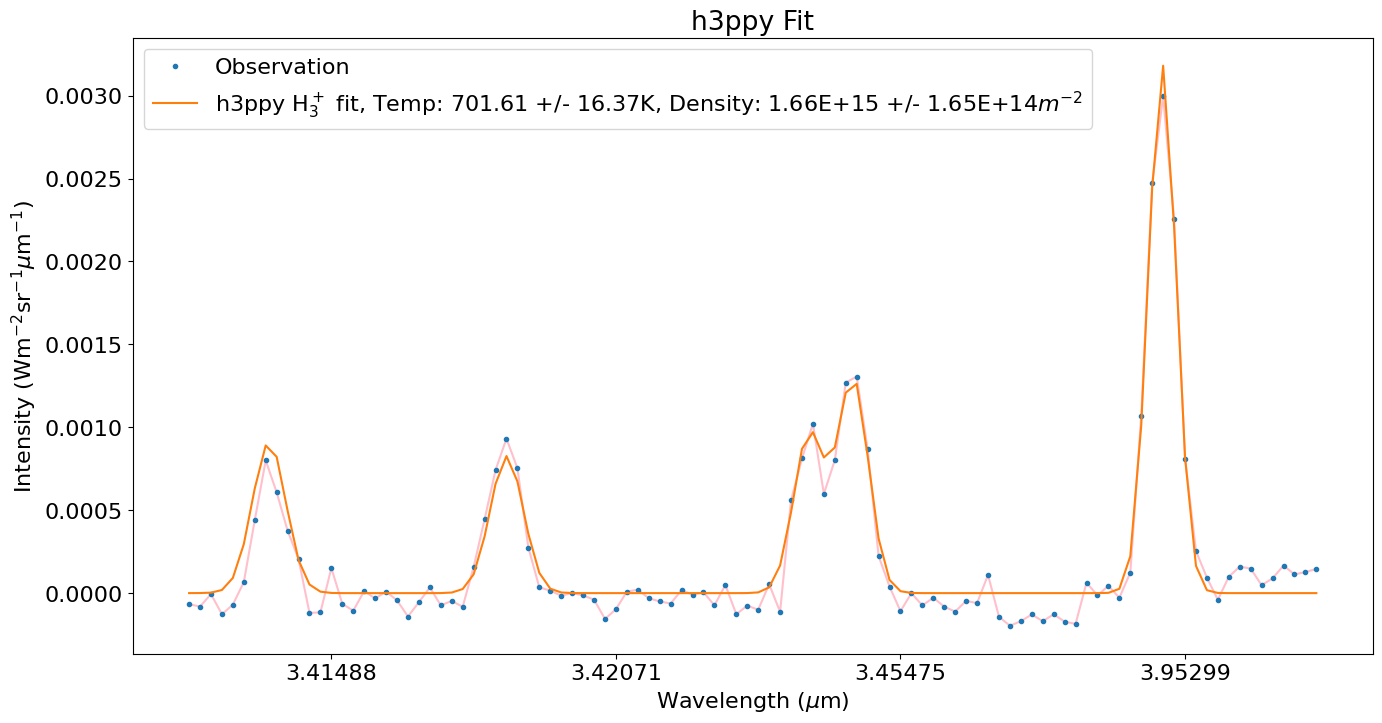

In [23]:
# Create a x scale for plotting 
xx      = list(range(len(subspec)))
xaxis = []
for i in range(len(xx)):
    xaxis.append(xx[i])
subspectest = []
for i in range(len(subspec)):
    subspectest.append(subspec[i])

widthpeak = np.average(widthpeaklist) #esitmate positions of peaks - could be better done but this is just for testing so it doesn't need to look good
cpos = np.arange(len(truecenters_multi)) * 2*widthpeak + widthpeak


fig, ax = plt.subplots(figsize=[16,8])

#plot data
ax.plot(xaxis, subspec, 'pink')
ax.plot(xaxis, subspec, '.', label='Observation')

#plot fit if the fit succeeded
if vars != False:
    ax.plot(xx, fit, label = 'h3ppy H$_3^+$ fit, Temp: ' 
            + str(round(vars['temperature'], 2)) + " +/- " + str(round(errs["temperature"],2)) + "K, Density: " 
           + str('%.2E' % vars['density']) + " +/- " + str('%.2E' % errs["density"]) + "$m^{-2}$"
           )

    
ax.set_title('h3ppy Fit')
ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(), xticks = cpos)
ax.set_xticklabels(truecenters_multi)
ax.legend(frameon = True)
plt.show()

In [24]:
#once you have things working well for a few different positions, you can try fitting the full slit worth of temperatures here:
#you shouldn't need to update anything in this actual cell; it takes a few min (5+) to run

In [25]:
jup = h3ppyfit_doubleorder_loop_multiwidth(wave_micron1st,wave_micron4th,jup1_data,jup4_data,truecenters_multi,truecenters_multi,temps,nbg,noff,nsig)

C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\

[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy


[h3ppy] Fit failed to converge - solution is numerially unstable 


C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\Local\anaconda3\Lib\site-packages\h3ppy
C:\Users\kater00\AppData\

In [26]:
#routine to make fancy looking error bars for plotting below (also to drop any failed fits)

def error_fillbetween(temperatures, errors):
    maxerror = []
    minerror = []
    
    for i in range(len(temperatures)):
        if temperatures[i] == -666 or errors[i] == -666:
            maxerror.append(np.nan)
        else:
            maxerrorvalue = temperatures[i] + errors[i]
            maxerror.append(maxerrorvalue)
    maxerror_arr = np.asarray(maxerror)
    
    
    for i in range(len(temperatures)):
        if temperatures[i] == -666 or errors[i] == -666:
            minerror.append(np.nan)
        else:
            minerrorvalue = temperatures[i] - errors[i]
            minerror.append(minerrorvalue)
    minerror_arr = np.asarray(minerror)
    
    return(minerror_arr, maxerror_arr)

C:\Users\kater00\AppData\Local\Temp\ipykernel_19524\83123562.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


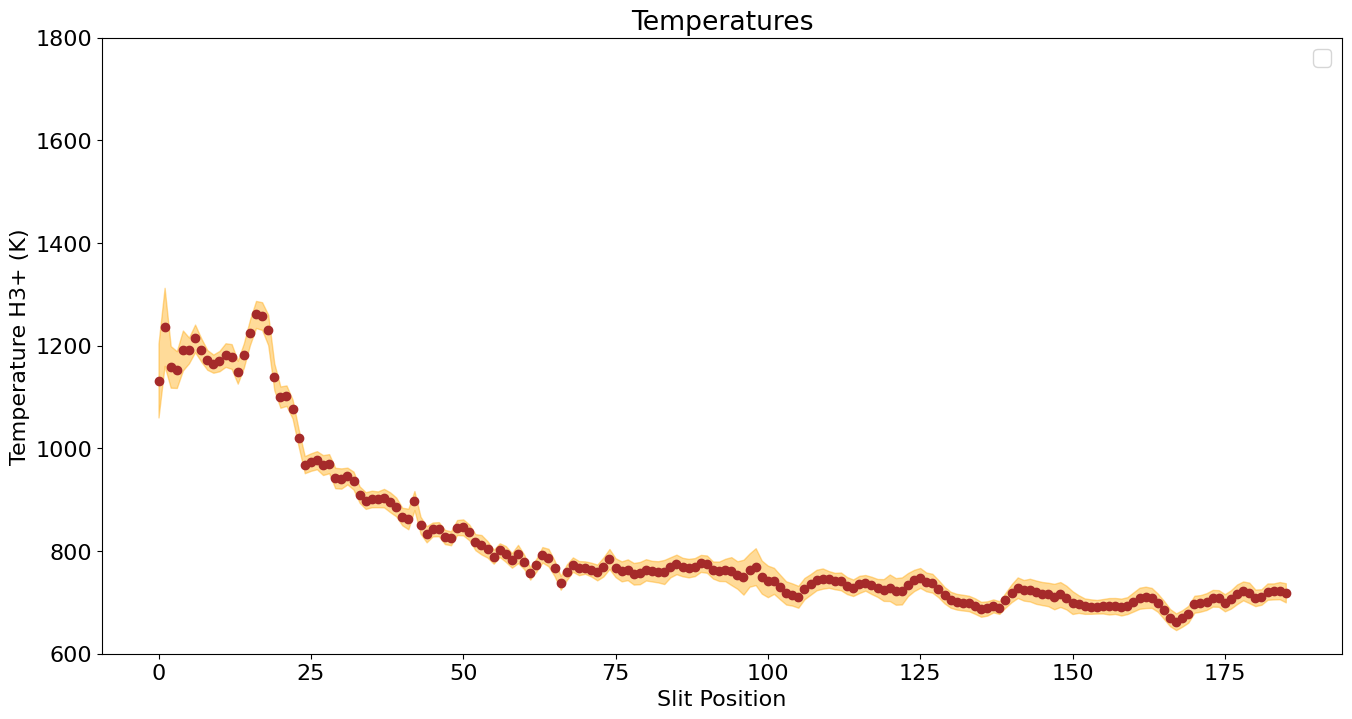

C:\Users\kater00\AppData\Local\Temp\ipykernel_19524\83123562.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


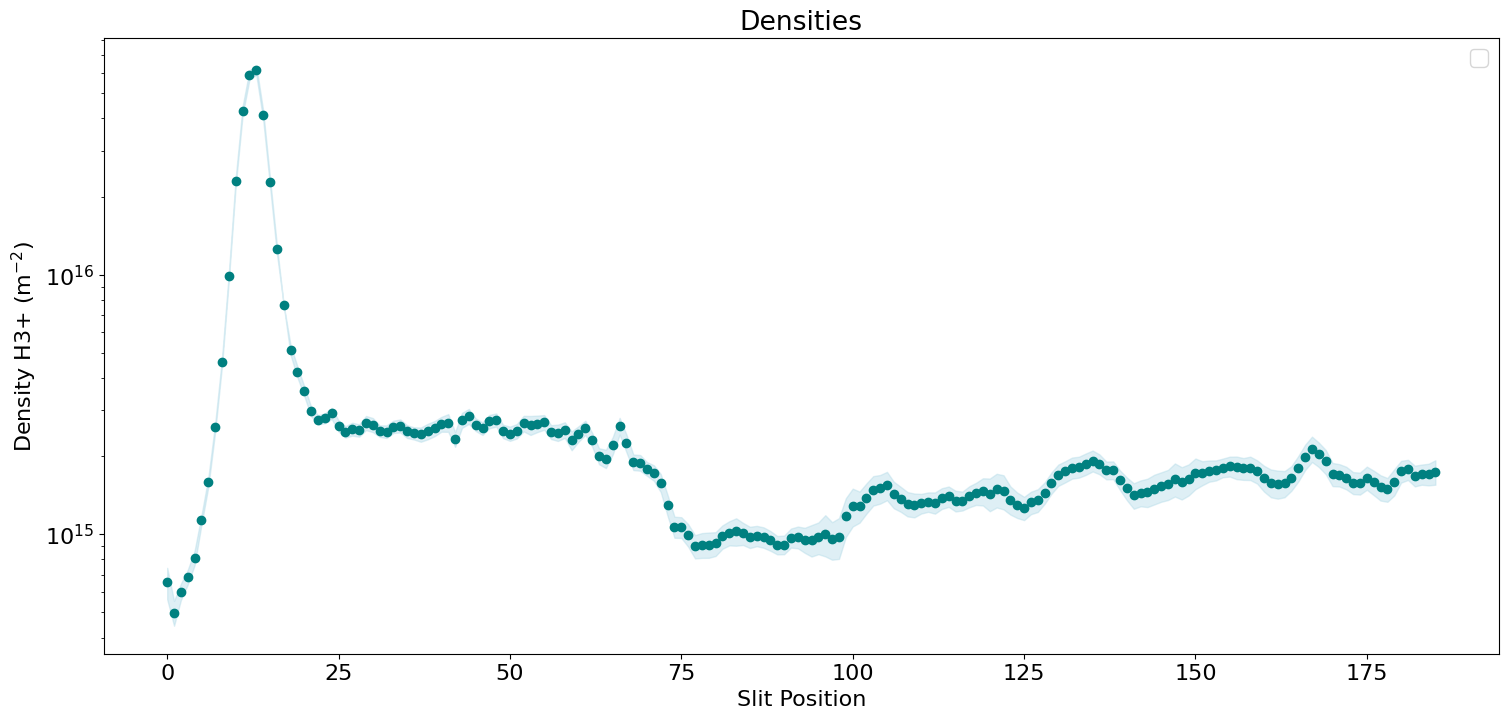

In [27]:
error = error_fillbetween(jup[0], jup[1])

plt.subplots(figsize=[16, 8])

plt.fill_between(range(len(jup[0])), error[0], error[1], color = "orange", alpha = 0.4)
plt.scatter(range(len(jup[0])), jup[0], color = "brown")

plt.ylim(600,1800)

plt.title("Temperatures")
plt.xlabel("Slit Position")
plt.ylabel("Temperature H3+ (K)")
plt.legend()
plt.show()



error_d = error_fillbetween(jup[2], jup[3])

plt.subplots(figsize=[18, 8])
plt.fill_between(range(len(jup[0])), error_d[0], error_d[1], color = "lightblue", alpha = 0.4)
plt.scatter(range(len(jup[2])), jup[2], color = "teal")


plt.title("Densities")
plt.xlabel("Slit Position")
plt.ylabel("Density H3+ (m$^{-2}$)")
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
#once you've tried a few different data files and they work satisfactorily, you can move over to the h3ppy Mass Fitting Routines notebook